# Reprise du projet 5 avec le jeux MNIST original
## Imports et fonctions

In [1]:
import numpy as np

import random

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier

import h5py

import time

import matplotlib.pyplot as plt 

from joblib import dump, load

from PIL import Image

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


2022-03-26 08:33:48.022663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 08:33:48.022698: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def erreur_prediction(valeurs_predites= None, valeurs_reelle= None):
    """
    Vérifie que les valeurs prédites sont les mêmes que les valeurs réelles.
    
    paramètres en entrée:
    valeurs_predites
    valeurs_reelle
    
    Paramètres de sortie:
    erreur: nombre d'erreur de prédiction
    precision: 100*(1-erreur/(longueur des tableaux)
    liste_erreur: Liste de toutes les erreurs détecté sous forme de dictionnaire 
        clé valeur réelle: valeur prédite
    """
    
    assert len(valeurs_predites) == len(valeurs_reelle), "Erreur de dimension: la dimension des tableaux "+\
        f"doit être identique. {len(valeurs_predites)} # de {len(valeurs_reelle)}"

    erreur= 0
    d= {}
    longueur= len(valeurs_reelle)
    for i in range(longueur):
        if valeurs_reelle[i]!= valeurs_predites[i]:
            if valeurs_reelle[i] not in d.keys():
                d[valeurs_reelle[i]]= [valeurs_predites[i]]
            else:
                d[valeurs_reelle[i]].append(valeurs_predites[i])
            erreur+= 1
        
    return erreur, 100*(1-erreur/longueur), d

## Reprise partielle du brief

In [3]:
# Importation des données depuis scikit learn datasets
digits = load_digits()

# Les images sont organisées en matrice de 8x8
X = digits.images
# Labels des images (chiffre de 0 à 9)
Y = digits.target
# Les images sont "applaties" et transformées en un tableau de 64 éléments 
Xdata= digits.data

print(f"X Shape: {X.shape}, Xdata Shape: {Xdata.shape}, Y shape: {Y.shape}, "+\
      f"digits.target_name: {digits.target_names}\n")

X Shape: (1797, 8, 8), Xdata Shape: (1797, 64), Y shape: (1797,), digits.target_name: [0 1 2 3 4 5 6 7 8 9]



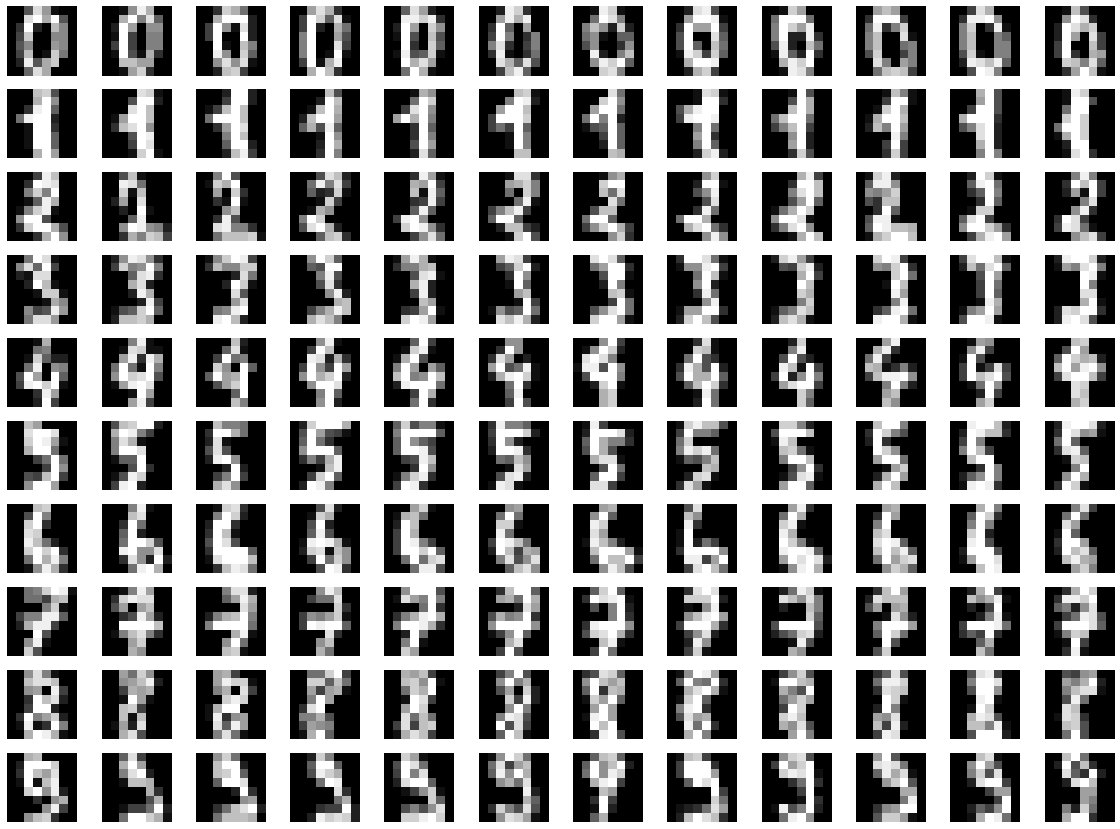

In [4]:
# Préparation de l'affichage
n_digits = np.unique(Y) # = 0,1,2,...9
M =12

fig, axs = plt.subplots(len(n_digits), M, figsize=(20, 15))

# Afficher M exemples de tout les digits (de 0 à 9)
for i, d in enumerate(n_digits):
    x= X[Y == d]
    for j in range(M):
        num= random.randint(0,x.shape[0]-1)        
        axs[i,j].imshow(X[Y == d][j], cmap="gray")
        axs[i,j].axis('off')

In [5]:
# On split le jeux de données
X_train, X_test, Y_train, Y_test = train_test_split(Xdata, Y, test_size=0.2, random_state= 511)

# On construit et on 'fit' le modèle
log_regr = LogisticRegression(solver='liblinear')
log_regr.fit(X_train, Y_train)

# on teste sur les données de.... test :)
prediction = log_regr.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test)
print(f"{err} erreurs sur {len(X_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

19 erreurs sur 360 images soit une précision de 94.72 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [1, 1, 1, 3, 1], 3: [5, 8], 9: [8, 3, 4, 8], 5: [9, 9, 9, 9], 4: [7, 6], 1: [6, 8]}


In [6]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("\n",classification_report(Y_test,prediction, target_names=target_names))



                 precision    recall  f1-score   support

détection de 0       1.00      1.00      1.00        31
détection de 1       0.89      0.94      0.91        33
détection de 2       1.00      1.00      1.00        35
détection de 3       0.94      0.94      0.94        36
détection de 4       0.97      0.95      0.96        41
détection de 5       0.98      0.91      0.94        45
détection de 6       0.95      1.00      0.97        35
détection de 7       0.97      1.00      0.98        31
détection de 8       0.90      0.88      0.89        40
détection de 9       0.88      0.88      0.88        33

      accuracy                           0.95       360
     macro avg       0.95      0.95      0.95       360
  weighted avg       0.95      0.95      0.95       360



# Reprise du brief 5 avec MNIST

## Importation et visualisation des données du dataset MNIST

In [3]:
# Importation du jeux d'entraînement
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()

etiquette= np.unique(test_y)
print(f"Entrainement: X Shape: {train_x.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {test_x.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28), Y shape: (60000,)
Test: X Shape: (10000, 28, 28), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


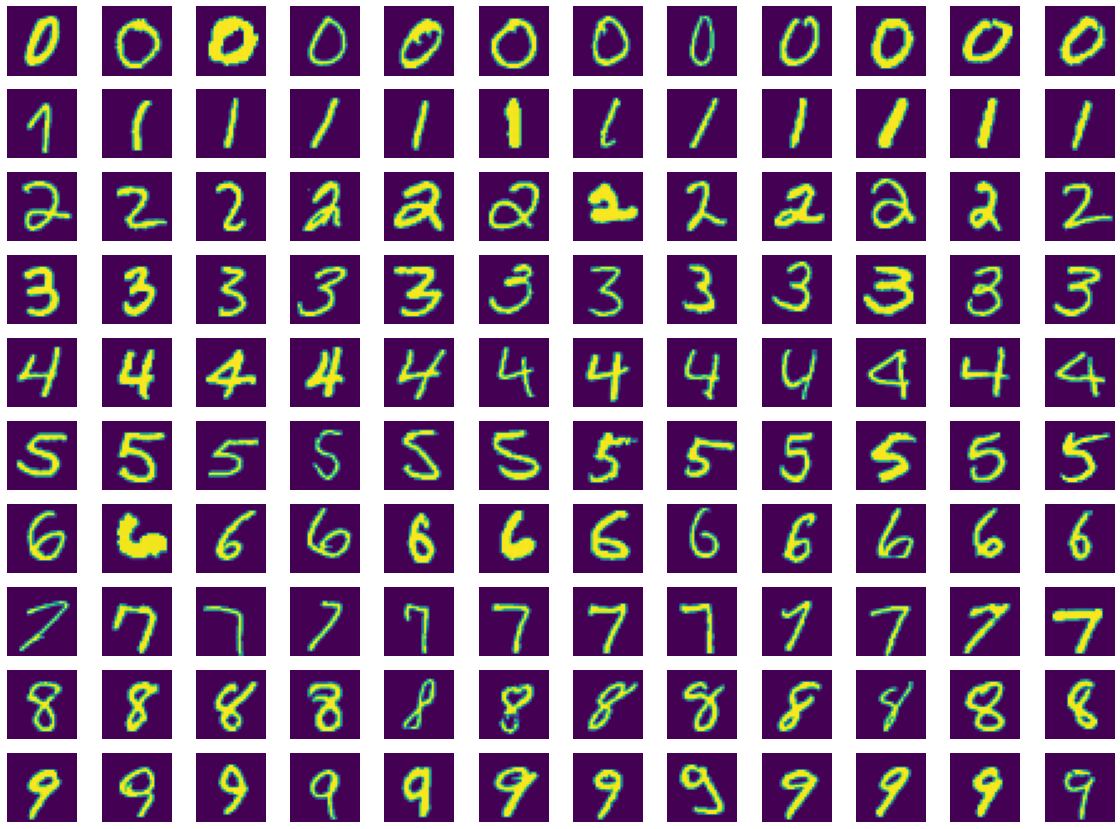

In [4]:
# Préparation de l'affichage
M= 12
fig, axs = plt.subplots(len(etiquette), M, figsize=(20, 15))

np.random.seed(51165)
# Afficher M exemples de tout les digits (de 0 à 9)
for i, d in enumerate(etiquette):
    x= train_x[train_y == d]
    for j in range(M):
        num= random.randint(0, x.shape[0]-1)        
        axs[i,j].imshow(x[num])
        axs[i,j].axis('off')


## On test en se plaçant dans les mêmes conditions que pour le brief 5

In [9]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(data_red, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [10]:
# Le jeux de donnée est-il équilibré ?
d= {}
for i in etiquette:
    l= len(X_train_red[Y_train_red== i])
    d[i]= l
    print(f"Le chiffre {i} est représenté {l} fois", end= " - ")
mini, maxi= min(d, key= d.get), max(d, key= d.get)
print(f"\nLe chiffre le moins représenté est {mini} représenté {d[mini]} fois.")
print(f"Le chiffre le plus représenté est {maxi} représenté {d[maxi]} fois.")

Le chiffre 0 est représenté 483 fois - Le chiffre 1 est représenté 546 fois - Le chiffre 2 est représenté 472 fois - Le chiffre 3 est représenté 483 fois - Le chiffre 4 est représenté 473 fois - Le chiffre 5 est représenté 431 fois - Le chiffre 6 est représenté 482 fois - Le chiffre 7 est représenté 480 fois - Le chiffre 8 est représenté 487 fois - Le chiffre 9 est représenté 463 fois - 
Le chiffre le moins représenté est 5 représenté 431 fois.
Le chiffre le plus représenté est 1 représenté 546 fois.


In [11]:
deb= time.time()
# On construit et on 'fit' le modèle
model_reglog = LogisticRegression(solver='liblinear')
model_reglog.fit(X_train_red, Y_train_red)
fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

temps d'exécution: 46.99 s


/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## On teste l'algorithme

In [12]:
# on teste sur les données de.... test :)
prediction = model_reglog.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

225 erreurs sur 1200 images soit une précision de 81.25 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 3, 5, 5, 5, 4, 5, 2, 3, 0, 3, 9, 1, 2, 9, 1, 2, 4, 9, 3, 3, 2, 9], 2: [3, 7, 9, 0, 7, 6, 8, 0, 9, 3, 7, 1, 3, 6, 1, 1, 5, 0, 0, 8, 5, 5, 8, 5, 8, 3, 6, 3, 8, 8, 7, 8, 3, 9, 8, 8], 5: [3, 3, 3, 9, 8, 8, 9, 3, 9, 6, 8, 4, 3, 9, 3, 3, 3, 3, 4, 3, 8, 2, 6, 6, 3, 9, 3, 3, 8, 8, 9, 9, 8, 3, 8, 6, 8], 9: [8, 8, 7, 4, 1, 8, 4, 4, 8, 4, 4, 8, 8, 2, 3, 8, 7, 8, 8, 4, 2, 7, 8, 8, 7], 3: [7, 5, 9, 8, 8, 8, 8, 2, 8, 8, 6, 2, 0, 9, 8, 0, 8, 8, 8, 5, 8, 7, 8, 8, 8, 5, 5, 8, 8, 5, 8, 8, 8, 8, 4, 8, 8, 8], 4: [9, 8, 7, 8, 2, 9, 0, 8, 3, 8, 2, 9, 2, 7, 8, 8, 9, 3, 9, 6, 9, 9, 7, 5, 0], 7: [1, 4, 4, 9, 3, 8, 3, 3, 1, 3, 9, 2, 5, 9, 9, 9, 8, 9, 9, 2, 5], 6: [8, 0, 5, 3, 8, 5, 8], 0: [6, 5, 4, 2, 6, 9, 8], 1: [3, 8, 3, 9, 3, 2]}


In [13]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("Le score obtenu est de {} % de bonne prédictions".
      format(round(model_reglog.score(X_test_red, Y_test_red)*100,2)))
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 

Le score obtenu est de 81.25 % de bonne prédictions

                 precision    recall  f1-score   support

détection de 0       0.92      0.94      0.93       126
détection de 1       0.93      0.95      0.94       117
détection de 2       0.86      0.74      0.80       137
détection de 3       0.67      0.66      0.66       112
détection de 4       0.88      0.80      0.83       123
détection de 5       0.78      0.64      0.70       103
détection de 6       0.92      0.95      0.93       135
détection de 7       0.88      0.82      0.85       119
détection de 8       0.57      0.79      0.66       110
détection de 9       0.74      0.79      0.77       118

      accuracy                           0.81      1200
     macro avg       0.82      0.81      0.81      1200
  weighted avg       0.82      0.81      0.81      1200



## Normalisation des données et test d'un nouveau solver

In [14]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# Standardisation
scaler=StandardScaler()
datastd= scaler.fit_transform(data_red)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(datastd, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [15]:
deb= time.time()
# On construit et on 'fit' le modèle
model_reglog = LogisticRegression(solver='lbfgs', class_weight= "balanced", max_iter= 2000)
model_reglog.fit(X_train_red, Y_train_red)
fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

temps d'exécution: 14.49 s


In [16]:
# on teste sur les données de.... test :)
prediction = model_reglog.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

126 erreurs sur 1200 images soit une précision de 89.50 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 5, 5, 3, 6, 2, 5, 2, 1, 3, 1, 3, 2, 1, 9], 2: [3, 8, 3, 7, 6, 1, 3, 4, 4, 3, 1, 0, 3, 1, 0, 7, 6, 7, 4, 7, 3, 6, 0, 9, 8, 3], 5: [3, 3, 8, 0, 3, 9, 4, 3, 1, 0, 9, 3, 6, 8, 4, 3, 9, 8, 9, 8, 0, 8, 8], 3: [5, 9, 8, 2, 8, 2, 0, 0, 5, 5, 7, 2, 8, 8], 9: [4, 1, 3, 4, 3, 4, 4, 2, 4, 3, 8, 8, 4, 7], 6: [8, 5, 0, 8, 5], 4: [3, 8, 2, 9, 8, 1, 9, 2, 8, 0], 1: [2, 3, 2], 0: [6, 5, 4, 6, 6, 7], 7: [4, 3, 9, 4, 9, 9, 1, 5, 9, 9]}


In [17]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print(f"Le score obtenu est de {model_reglog.score(X_test_red, Y_test_red)*100:.2f}")
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 


Le score obtenu est de 89.50

                 precision    recall  f1-score   support

détection de 0       0.92      0.95      0.94       126
détection de 1       0.92      0.97      0.95       117
détection de 2       0.91      0.81      0.86       137
détection de 3       0.81      0.88      0.84       112
détection de 4       0.89      0.92      0.90       123
détection de 5       0.89      0.78      0.83       103
détection de 6       0.94      0.96      0.95       135
détection de 7       0.94      0.92      0.93       119
détection de 8       0.83      0.86      0.85       110
détection de 9       0.88      0.88      0.88       118

      accuracy                           0.90      1200
     macro avg       0.89      0.89      0.89      1200
  weighted avg       0.90      0.90      0.89      1200



## Gridsearch CV pour déterminer la meilleure standardisation et le meilleur solver pour la régression logistique

In [18]:
# On récupère les données. On ne prendra qu'une partie des données situé dans le
#  jeux de train. On en profite pour "applatir" les images
data= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])

# On réduit le jeux de données original
data_red, _, Y_red, _=  train_test_split(data, train_y, train_size=0.1, random_state= 65)

# On split le jeux de données
X_train_red, X_test_red,  Y_train_red, Y_test_red = train_test_split(data_red, Y_red, train_size=0.8, 
                                                               random_state= 65)

print(f"Entrainement: X Shape: {X_train_red.shape}, Y shape: {Y_train_red.shape}\n"+\
      f"Test: X Shape: {X_test_red.shape}, Y shape: {Y_test_red.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (4800, 784), Y shape: (4800,)
Test: X Shape: (1200, 784), Y shape: (1200,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [19]:
# On réalise un pipe avec 2 actions: un scaler et un algorithme
pipe = Pipeline(steps= [('scaler', StandardScaler()), ('algo', LogisticRegression())])

# On testera 3 standardisations et pour la régression logistique on testera tout les solvers
param_grid = {'pipeline__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
              'pipeline__algo__solver': ["sag", "newton-cg", "lbfgs", "saga"],
              'pipeline__algo__class_weight': ["balanced"],
              'pipeline__algo__max_iter': [2000]}
# instantiate and run as before:

model= make_pipeline(pipe)

grid = GridSearchCV(model, param_grid, cv=5, n_jobs= -1)

grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler()),
                                                        ('algo',
                                                         LogisticRegression())]))]),
             n_jobs=-1,
             param_grid={'pipeline__algo__class_weight': ['balanced'],
                         'pipeline__algo__max_iter': [2000],
                         'pipeline__algo__solver': ['sag', 'newton-cg', 'lbfgs',
                                                    'saga'],
                         'pipeline__scaler': [StandardScaler(), MinMaxScaler(),
                                              RobustScaler()]})

In [20]:
deb= time.time()

grid.fit(X_train_red, Y_train_red)

fin= time.time()
print(f"temps d'exécution: {fin-deb:.2f} s")

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_log

temps d'exécution: 8379.82 s


In [28]:
grid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('algo',
                                  LogisticRegression(class_weight='balanced',
                                                     max_iter=2000,
                                                     solver='newton-cg'))]))])

In [29]:
print(f"Précision obtenu: {100*grid.best_score_:.2f} %")

Précision obtenu: 88.40 %


In [31]:
# on teste sur les données de.... test :)
prediction = grid.best_estimator_.predict(X_test_red)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

111 erreurs sur 1200 images soit une précision de 90.75 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{8: [3, 5, 5, 5, 3, 2, 5, 1, 5, 3, 1, 3, 1, 9], 2: [7, 8, 0, 7, 1, 3, 4, 7, 3, 1, 0, 1, 7, 6, 7, 6, 7, 3, 6, 8, 8, 8, 3], 5: [3, 3, 8, 3, 9, 4, 3, 0, 9, 3, 3, 9, 8, 0, 8, 8], 7: [5, 4, 3, 9, 9, 9, 9, 2, 5, 9, 9], 3: [8, 2, 5, 2, 0, 9, 0, 5, 5, 8, 7, 2, 8, 8], 6: [8, 5, 7, 5, 5], 4: [3, 2, 9, 8, 1, 9, 9, 8, 8, 8, 0], 0: [6, 5, 4], 9: [1, 4, 4, 8, 4, 7, 3, 3, 7, 8, 4, 7], 1: [3, 3]}


In [32]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("\n",classification_report(Y_test_red,prediction, target_names= target_names)) 


                 precision    recall  f1-score   support

détection de 0       0.95      0.98      0.96       126
détection de 1       0.93      0.98      0.96       117
détection de 2       0.95      0.83      0.89       137
détection de 3       0.83      0.88      0.85       112
détection de 4       0.93      0.91      0.92       123
détection de 5       0.86      0.84      0.85       103
détection de 6       0.97      0.96      0.97       135
détection de 7       0.91      0.91      0.91       119
détection de 8       0.83      0.87      0.85       110
détection de 9       0.88      0.90      0.89       118

      accuracy                           0.91      1200
     macro avg       0.91      0.91      0.91      1200
  weighted avg       0.91      0.91      0.91      1200



## Entrainement de l'algorithme de la regression logistique avec la totalité du jeux MNIST normalisé avec min/max.

In [3]:
# Importation du jeux d'entraînement. On réalise directement une normalisation min/max en divisant par 255.0
#  Les pixels composant l'image étant compris entre 0 et 255
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()

etiquette= np.unique(test_y)
print(f"Entrainement: X Shape: {train_x.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {test_x.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28), Y shape: (60000,)
Test: X Shape: (10000, 28, 28), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [4]:
X_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
Y_train= train_y

X_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])
Y_test= test_y

In [7]:
model_reglog= LogisticRegression(class_weight='balanced', max_iter=2000, solver='newton-cg')
deb= time.time()
model_reglog.fit(X_train, Y_train)
fin= time.time()
print(f"fit en {fin-deb} s")

fit en 328.4471061229706 s


In [8]:
prediction = model_reglog.predict(X_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test)
print(f"{err} erreurs sur {len(X_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

737 erreurs sur 10000 images soit une précision de 92.63 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{5: [6, 7, 3, 0, 8, 3, 8, 8, 3, 7, 8, 9, 3, 4, 3, 8, 3, 6, 7, 6, 3, 0, 8, 0, 3, 3, 4, 9, 8, 8, 8, 4, 8, 3, 2, 8, 7, 3, 8, 0, 3, 3, 2, 0, 7, 7, 9, 9, 4, 0, 8, 4, 8, 0, 2, 3, 3, 3, 1, 6, 8, 8, 4, 3, 8, 6, 3, 8, 6, 8, 8, 1, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 6, 4, 8, 6, 8, 3, 6, 8, 8, 8, 4, 4, 8, 8, 3, 6, 3, 3, 3, 6, 6, 0, 0, 6, 6, 3, 6], 4: [6, 6, 2, 9, 9, 9, 9, 8, 9, 1, 6, 9, 6, 9, 9, 9, 3, 7, 3, 6, 8, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 2, 9, 2, 2, 9, 1, 6, 9, 2, 6, 9, 9, 1, 6, 9, 3, 7, 0, 9, 8, 9, 8, 8, 9, 9, 9, 7, 2, 9, 8], 3: [2, 5, 5, 5, 7, 5, 2, 6, 5, 2, 5, 5, 8, 5, 9, 8, 7, 9, 8, 7, 7, 5, 7, 5, 1, 8, 5, 9, 5, 5, 6, 5, 0, 2, 7, 5, 5, 2, 2, 2, 8, 5, 2, 2, 7, 7, 7, 5, 9, 8, 5, 2, 8, 5, 8, 4, 0, 9, 0, 8, 8, 5, 8, 8, 8, 8, 8, 7, 5, 8, 2, 2, 2, 2, 8, 8, 5, 8, 8, 5, 8, 2, 0, 9, 2, 8, 9, 8], 6: [2, 5, 0, 0, 0, 5, 2, 2, 1, 8, 7, 7, 5, 4, 0, 2, 1, 5, 4, 5, 1, 2, 4, 0, 3, 0, 4, 5

In [9]:
target_names= ["détection de 0", "détection de 1", "détection de 2", "détection de 3", "détection de 4",
               "détection de 5", "détection de 6", "détection de 7", "détection de 8", "détection de 9"]
print("\n",classification_report(Y_test,prediction, target_names= target_names)) 


                 precision    recall  f1-score   support

détection de 0       0.95      0.97      0.96       980
détection de 1       0.97      0.98      0.97      1135
détection de 2       0.93      0.90      0.92      1032
détection de 3       0.91      0.91      0.91      1010
détection de 4       0.94      0.94      0.94       982
détection de 5       0.89      0.88      0.89       892
détection de 6       0.94      0.95      0.95       958
détection de 7       0.94      0.92      0.93      1028
détection de 8       0.88      0.88      0.88       974
détection de 9       0.91      0.92      0.92      1009

      accuracy                           0.93     10000
     macro avg       0.93      0.93      0.93     10000
  weighted avg       0.93      0.93      0.93     10000



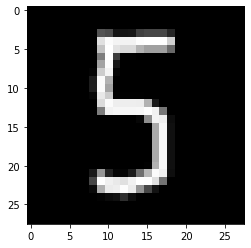

In [3]:
img= Image.open("./images/5_001.png")
_=plt.imshow(img, cmap= "gray")

In [12]:
chiffre=np.array(img)/255.
chiffre_plat= chiffre.ravel()
tab= list(model_reglog.predict_proba([chiffre_plat])[0])
print(f"Le chiffre le plus probable est: {tab.index(max(tab))}\nListe des probabilités:{tab}")

Le chiffre le plus probable est: 5
Liste des probabilités:[0.00010985476550631836, 6.972696327770812e-07, 0.008636546996151222, 0.369270499667964, 0.0004235051156176312, 0.3821188287201187, 0.00019094647377095294, 1.4248341358281702e-10, 0.23924762938532074, 1.4914634344104556e-06]


### Enregistrement du modèle

In [21]:
dump(model_reglog, 'RegressionLogistique_newton_balanced.modele') 

['RegressionLogistique_newton_balanced.modele']

## Learning curve
On fera cette étude en prenant l'intégralité du jeux de données avec le meilleur solver.

In [33]:
# On récupère les données et on en profite pour "applatir" les images
data_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
data_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])

etiquette= np.unique(test_y)

print(f"Entrainement: X Shape: {data_train.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 784), Y shape: (60000,)
Test: X Shape: (10000, 784), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [34]:
# On choisi le meilleur solver avec une standardisation min/max
pipe_minmax_logreg= make_pipeline(MinMaxScaler(), LogisticRegression(class_weight='balanced', 
                                                                      max_iter=2000, solver='newton-cg'))

pipe_minmax_logreg.fit(data_train, train_y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='newton-cg'))])

In [35]:
prediction = pipe_minmax_logreg.predict(data_test)

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= test_y)
print(f"{err} erreurs sur {len(data_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

737 erreurs sur 10000 images soit une précision de 92.63 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{5: [6, 7, 3, 0, 8, 3, 8, 8, 3, 7, 8, 9, 3, 4, 3, 8, 3, 6, 7, 6, 3, 0, 8, 0, 3, 3, 4, 9, 8, 8, 8, 4, 8, 3, 2, 8, 7, 3, 8, 0, 3, 3, 2, 0, 7, 7, 9, 9, 4, 0, 8, 4, 8, 0, 2, 3, 3, 3, 1, 6, 8, 8, 4, 3, 8, 6, 3, 8, 6, 8, 8, 1, 3, 3, 3, 3, 3, 3, 8, 3, 8, 8, 3, 6, 4, 8, 6, 8, 3, 6, 8, 8, 8, 4, 4, 8, 8, 3, 6, 3, 3, 3, 6, 6, 0, 0, 6, 6, 3, 6], 4: [6, 6, 2, 9, 9, 9, 9, 8, 9, 1, 6, 9, 6, 9, 9, 9, 3, 7, 3, 6, 8, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 2, 9, 9, 2, 2, 9, 1, 9, 2, 6, 9, 9, 1, 6, 9, 3, 7, 0, 9, 8, 9, 8, 8, 9, 9, 9, 7, 2, 9, 8], 3: [2, 5, 5, 5, 7, 5, 2, 6, 5, 2, 5, 5, 8, 5, 9, 8, 7, 9, 8, 7, 7, 5, 7, 5, 1, 8, 5, 9, 5, 5, 6, 5, 0, 2, 7, 5, 5, 2, 2, 2, 8, 5, 2, 2, 7, 7, 7, 5, 9, 8, 5, 2, 8, 5, 8, 4, 2, 0, 9, 0, 8, 8, 5, 8, 8, 8, 8, 8, 7, 5, 8, 2, 2, 2, 2, 8, 8, 5, 8, 8, 5, 8, 2, 0, 9, 2, 8, 9, 8], 6: [2, 5, 0, 0, 0, 5, 2, 2, 1, 8, 7, 7, 5, 4, 0, 2, 1, 5, 4, 5, 1, 2, 4, 0, 3, 0, 4

In [36]:
train_size, train_score, val_score= learning_curve(pipe_minmax_logreg, data_train, train_y, 
                                          train_sizes= np.linspace(0.05,1,20), cv= 3)

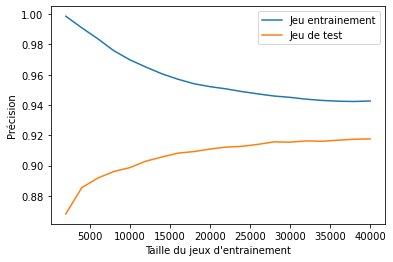

In [37]:
plt.plot(train_size, train_score.mean(axis=1), label= "Jeu entrainement")
plt.plot(train_size, val_score.mean(axis=1), label= "Jeu de test")
plt.xlabel("Taille du jeux d'entrainement")
plt.ylabel("Précision")
_= plt.legend()

## Recherche de nouveau algo - KNN classifier

In [39]:
# On récupère les données et on en profite pour "applatir" les images
data_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
data_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])

etiquette= np.unique(test_y)

print(f"Entrainement: X Shape: {data_train.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 784), Y shape: (60000,)
Test: X Shape: (10000, 784), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [40]:
# On choisi les meilleurs paramètres en gardant la standardisation min/max
pipe_minmax_knn= make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors= 6, weights= "distance",
                                                                    algorithm='ball_tree', p= 3))

pipe_minmax_knn.fit(data_train, train_y)
prediction = pipe_minmax_knn.predict(data_test)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=6, p=3,
                                      weights='distance'))])

In [42]:
err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= test_y)
print(f"{err} erreurs sur {len(data_test)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

263 erreurs sur 10000 images soit une précision de 97.37 %
Dictionnaire des erreurs (clé valeur réelle: valeur prédite):
{4: [0, 9, 6, 1, 9, 9, 9, 6, 9, 1, 9, 8, 9, 9, 9, 6, 6, 9, 9, 9, 1, 7, 1, 9, 7, 1, 1, 9, 9], 3: [5, 7, 7, 5, 5, 9, 7, 4, 5, 2, 5, 5, 5, 7, 7, 5, 7, 5, 5, 8, 2, 7, 6, 8, 9, 5, 9, 5, 9, 5, 5, 9, 8], 9: [8, 7, 8, 4, 0, 3, 5, 3, 4, 2, 6, 1, 4, 7, 0, 7, 1, 7, 4, 1, 1, 3, 3, 2, 7, 7, 2, 4, 1, 4, 5, 3, 5, 0, 0, 0, 7, 7, 4], 2: [7, 8, 7, 6, 7, 7, 0, 7, 0, 7, 0, 7, 1, 0, 7, 6, 1, 1, 3, 7, 7, 3, 7, 7, 7, 0, 7, 0, 1, 7, 0, 0, 0, 8, 7, 8, 0], 6: [4, 0, 5, 0, 1, 4, 5, 1, 0, 4, 0, 1, 0], 7: [4, 1, 4, 2, 1, 1, 1, 9, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 9, 9, 9, 9, 1, 1, 1, 9, 9, 9, 9, 1, 1, 2, 2, 2], 8: [0, 1, 3, 3, 3, 9, 4, 3, 3, 7, 4, 5, 3, 2, 4, 2, 3, 3, 6, 6, 3, 5, 0, 0, 5, 2, 7, 9, 3, 7, 6, 0, 6, 2, 4, 9, 9, 7, 9, 4, 5, 5], 5: [9, 4, 3, 6, 9, 7, 3, 6, 8, 8, 3, 9, 9, 0, 8, 4, 6, 3, 6, 9, 6, 6, 0, 6, 0, 6], 1: [2, 2, 6], 0: [6, 2, 7, 5, 6, 1, 6]}


In [43]:
# Sauvegarde du modèle
dump(pipe_minmax_knn, 'minmax_knn6_distance_balltreep3.modele') 

['minmax_knn6_distance_balltreep3.modele']

### Plutot que d'integrer le min max dans le modèle on demandera à ce que la normalisation soit faite avant
Pour avoir un modèle compatible avec les autre modèle pour le traitement et la comparaison avec les autres algorithme, on "sort" la normalisation du modèle.

In [3]:
# Importation du jeux d'entraînement. On réalise directement une normalisation min/max en divisant par 255.0
#  Les pixels composant l'image étant compris entre 0 et 255
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()

etiquette= np.unique(test_y)
print(f"Entrainement: X Shape: {train_x.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {test_x.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28), Y shape: (60000,)
Test: X Shape: (10000, 28, 28), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


In [4]:
X_train= train_x.reshape(train_x.shape[0], train_x.shape[1]*train_x.shape[2])
Y_train= train_y

X_test= test_x.reshape(test_x.shape[0], test_x.shape[1]*test_x.shape[2])
Y_test= test_y

In [5]:
model_knn= KNeighborsClassifier(algorithm='ball_tree', n_neighbors=6, p=3, weights='distance')
deb= time.time()
model_knn.fit(X_train, Y_train)
fin= time.time()
print(f"fit en {fin-deb} s")

fit en 16.260356187820435 s


In [6]:
dump(model_knn,"KNN_n6p3_distance_balltreep3.modele")

['KNN_n6p3_distance_balltreep3.modele']

#### Test sur une image non issue de MNIST

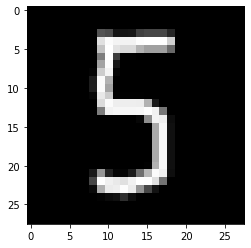

In [43]:
img= Image.open("./images/5_001.png")
plt.imshow(img, cmap= "gray")

In [46]:
chiffre=np.array(img)/255.0
chiffre= chiffre.ravel()
tab= list(model_knn.predict_proba([chiffre])[0])
print(tab.index(max(tab)))
print(100 * np.round(tab,4))

5
[ 0.    0.    0.   16.18  0.   83.82  0.    0.    0.    0.  ]


## Test d'un CNN
On normalisera le jeux de données en divisant chaque élément par 255.0 ce qui les transforme en flottant compris entre 0 et 1.

In [3]:
# Importation du jeux d'entraînement
f = h5py.File("./datas/train.hdf5", 'r')
train_x, train_y = (f['image'][...])/255.0, f['label'][...]
f.close()

# Importation du jeux de test
f = h5py.File("./datas/test.hdf5", 'r')
test_x, test_y = (f['image'][...])/255.0, f['label'][...]
f.close()

In [5]:
# On récupère les données et on les met en forme pour qu'elles soient compatible avec le CNN.
# la dimension des données de test et de train sont de type:
#  (shape[0],shape[1], shape[2]), il sera nécessaire d'y ajouter une dimension supplémentaire
data_train_pour_cnn= train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
data_test_pour_cnn= test_x.reshape(test_x.shape[0], test_x.shape[1], test_x.shape[2], 1)

etiquette= np.unique(test_y)

# convert class vectors to binary class matrices
train_y_conv = keras.utils.to_categorical(train_y, len(etiquette))
test_y_conv = keras.utils.to_categorical(test_y, len(etiquette))


print(f"Entrainement: X Shape: {data_train_pour_cnn.shape}, Y shape: {train_y.shape}\n"+\
      f"Test: X Shape: {data_test_pour_cnn.shape}, Y shape: {test_y.shape}\n"+\
      f"Etiquette: {etiquette}")

Entrainement: X Shape: (60000, 28, 28, 1), Y shape: (60000,)
Test: X Shape: (10000, 28, 28, 1), Y shape: (10000,)
Etiquette: [0 1 2 3 4 5 6 7 8 9]


#### Conception du réseau
2 versions de se réseau ont été faite, une avec dropout, l'autre sans. Sur les jeux de test et d'entraînement, les courbes sont trés proche et les résultats obtenus similaire. A voir sur des cas "réel" si les 2 réseaux se distinguent.

In [70]:
batch_size = 128
epochs = 250

input_shape= (train_x.shape[1], train_x.shape[2], 1)
nb_classe= len(etiquette)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape= input_shape ))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classe, activation='softmax'))
model.compile(loss= keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2359552   
                                                      

In [9]:
hist = model.fit(data_train_pour_cnn, train_y_conv, batch_size=batch_size, epochs=epochs, 
                 verbose=1,validation_data=(data_test_pour_cnn, test_y_conv), workers= -1)

Epoch 1/251
469/469 [==============================] - 278s 589ms/step - loss: 5.2512 - accuracy: 0.4805 - val_loss: 1.7019 - val_accuracy: 0.7154
Epoch 2/251
469/469 [==============================] - 253s 540ms/step - loss: 1.2893 - accuracy: 0.7795 - val_loss: 0.9239 - val_accuracy: 0.8355
Epoch 3/251
469/469 [==============================] - 255s 544ms/step - loss: 0.8350 - accuracy: 0.8492 - val_loss: 0.6893 - val_accuracy: 0.8729
Epoch 4/251
469/469 [==============================] - 259s 551ms/step - loss: 0.6502 - accuracy: 0.8787 - val_loss: 0.5698 - val_accuracy: 0.8959
Epoch 5/251
469/469 [==============================] - 259s 551ms/step - loss: 0.5416 - accuracy: 0.8957 - val_loss: 0.4912 - val_accuracy: 0.9078
Epoch 6/251
469/469 [==============================] - 258s 551ms/step - loss: 0.4677 - accuracy: 0.9079 - val_loss: 0.4409 - val_accuracy: 0.9135
Epoch 7/251
469/469 [==============================] - 259s 553ms/step - loss: 0.4127 - accuracy: 0.9160 - val_loss: 0

469/469 [==============================] - 269s 573ms/step - loss: 0.0088 - accuracy: 0.9986 - val_loss: 0.0980 - val_accuracy: 0.9756
Epoch 112/251
469/469 [==============================] - 267s 568ms/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 0.0982 - val_accuracy: 0.9756
Epoch 113/251
469/469 [==============================] - 289s 616ms/step - loss: 0.0083 - accuracy: 0.9988 - val_loss: 0.0982 - val_accuracy: 0.9762
Epoch 114/251
469/469 [==============================] - 256s 546ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0982 - val_accuracy: 0.9756
Epoch 115/251
469/469 [==============================] - 254s 543ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 0.0986 - val_accuracy: 0.9761
Epoch 116/251
469/469 [==============================] - 256s 546ms/step - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.0973 - val_accuracy: 0.9760
Epoch 117/251
469/469 [==============================] - 258s 549ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0

Epoch 221/251
469/469 [==============================] - 367s 781ms/step - loss: 7.6309e-04 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9803
Epoch 222/251
469/469 [==============================] - 296s 630ms/step - loss: 7.4825e-04 - accuracy: 1.0000 - val_loss: 0.0915 - val_accuracy: 0.9803
Epoch 223/251
469/469 [==============================] - 323s 688ms/step - loss: 7.3930e-04 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9804
Epoch 224/251
469/469 [==============================] - 312s 667ms/step - loss: 7.2445e-04 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9808
Epoch 225/251
469/469 [==============================] - 326s 696ms/step - loss: 7.2608e-04 - accuracy: 0.9999 - val_loss: 0.0913 - val_accuracy: 0.9805
Epoch 226/251
469/469 [==============================] - 316s 674ms/step - loss: 7.0618e-04 - accuracy: 0.9999 - val_loss: 0.0913 - val_accuracy: 0.9803
Epoch 227/251
469/469 [==============================] - 432s 921ms/step - loss: 6

#### Evaluation et sauvegarde du modèle.
Les noms seront par la suite changer pour pouvoir être manipuler plus simplement en fonction des contraintes du programme de visualition et de test.

In [11]:
score = model.evaluate(data_test_pour_cnn, test_y_conv, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 16s 52ms/step - loss: 0.0916 - accuracy: 0.9809
Test loss: 0.09160742163658142
Test accuracy: 0.98089998960495


In [ ]:
nom_modele= f"mnist_{epochs}.modele"
model.save(nom_modele)
print(f"sauvegarde du modèle {nom_modele}.")

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2359552   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                      

In [25]:
hist.history

{'loss': [22.571229934692383,
  10.335871696472168,
  6.109948635101318,
  4.1272125244140625,
  3.1016037464141846,
  2.4336371421813965,
  2.041743278503418,
  1.7853261232376099,
  1.6038233041763306,
  1.458308219909668,
  1.3760160207748413,
  1.2875343561172485,
  1.2264832258224487,
  1.1609575748443604,
  1.121896743774414,
  1.0787242650985718,
  1.0318491458892822,
  0.9977041482925415,
  0.9545130133628845,
  0.9364075660705566,
  0.8979724049568176,
  0.8775693774223328,
  0.8555898666381836,
  0.8221238255500793,
  0.8000975847244263,
  0.7885547280311584,
  0.7681276202201843,
  0.7530555129051208,
  0.7319848537445068,
  0.7208031415939331,
  0.7034688591957092,
  0.6904558539390564,
  0.6759500503540039,
  0.6622772812843323,
  0.6488083600997925,
  0.6314892172813416,
  0.6228706240653992,
  0.6187745332717896,
  0.5985718369483948,
  0.5916908979415894,
  0.5722251534461975,
  0.580276608467102,
  0.5594924092292786,
  0.555302083492279,
  0.5417608022689819,
  0.5354

In [58]:
class cl:
    history= d

hist= cl()

#hist.history

#### Tracé des courbes d'évolution de la perte et de la précision

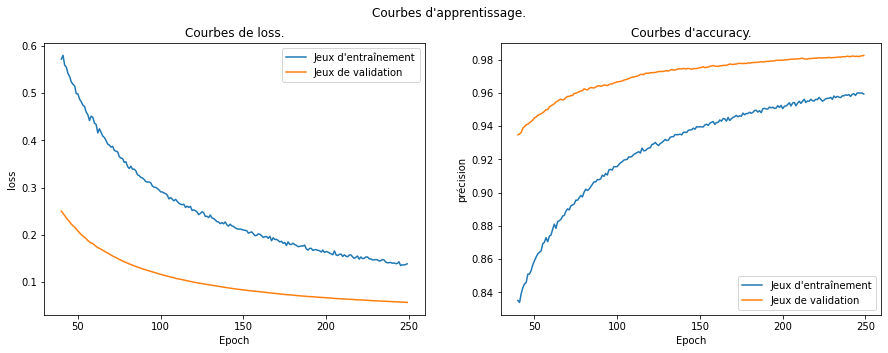

In [63]:
x= range(len(hist.history["loss"]))
debut= 40

fig, axes= plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("Courbes d'apprentissage.")

axes[0].plot(x[debut:], hist.history["loss"][debut:], label="Jeux d'entraînement")
axes[0].plot(x[debut:],hist.history["val_loss"][debut:], label="Jeux de validation")
axes[0].set_title("Courbes de loss.")
axes[0].set(xlabel= "Epoch", ylabel="loss")
axes[0].legend()

axes[1].plot(x[debut:],hist.history["accuracy"][debut:], label="Jeux d'entraînement")
axes[1].plot(x[debut:],hist.history["val_accuracy"][debut:], label="Jeux de validation")
axes[1].set_title("Courbes d'accuracy.")
axes[1].set(xlabel= "Epoch", ylabel="précision")
_= axes[1].legend()

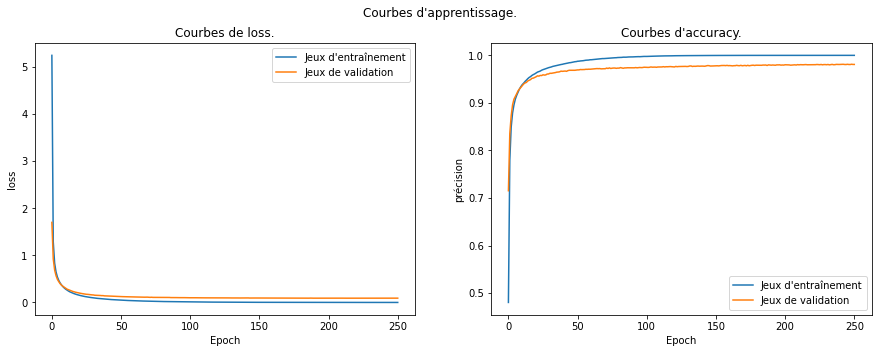

In [15]:
def affiche_courbes(d= None):
    for k in d.keys():
        print(k)

"""
plt.plot(x, d["loss"], label= "Jeu entrainement")
plt.plot(x, d["val_loss"], label= "Jeu de test")
plt.xlabel("Taille du jeux d'entrainement")
plt.ylabel("Précision")
_= plt.legend()
"""
x= range(len(hist.history["loss"]))

fig, axes= plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("Courbes d'apprentissage.")
axes[0].plot(x, hist.history["loss"], label="Jeux d'entraînement")
axes[0].plot(x,hist.history["val_loss"], label="Jeux de validation")
axes[0].set_title("Courbes de loss.")
axes[0].set(xlabel= "Epoch", ylabel="loss")
axes[0].legend()

axes[1].plot(x,hist.history["accuracy"], label="Jeux d'entraînement")
axes[1].plot(x,hist.history["val_accuracy"], label="Jeux de validation")
axes[1].set_title("Courbes d'accuracy.")
axes[1].set(xlabel= "Epoch", ylabel="précision")
_= axes[1].legend()

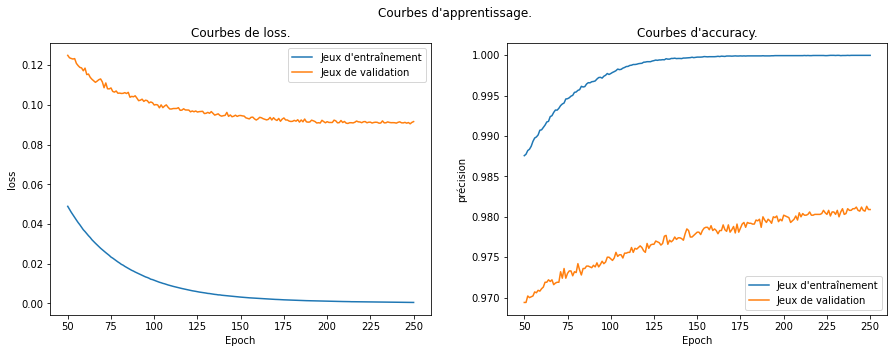

In [23]:
debut= 50
x= [x for x in range(len(hist.history["loss"]))]

fig, axes= plt.subplots(1, 2, figsize= (15,5))
fig.suptitle("Courbes d'apprentissage.")
axes[0].plot(x[debut:], hist.history["loss"][debut:], label="Jeux d'entraînement")
axes[0].plot(x[debut:],hist.history["val_loss"][debut:], label="Jeux de validation")
axes[0].set_title("Courbes de loss.")
axes[0].set(xlabel= "Epoch", ylabel="loss")
axes[0].legend()

axes[1].plot(x[debut:],hist.history["accuracy"][debut:], label="Jeux d'entraînement")
axes[1].plot(x[debut:],hist.history["val_accuracy"][debut:], label="Jeux de validation")
axes[1].set_title("Courbes d'accuracy.")
axes[1].set(xlabel= "Epoch", ylabel="précision")
_= axes[1].legend()

In [10]:
plt.figure(figsize= (7, 7))
plt.plot(x, d["accuracy"], label= "Jeu entrainement")
plt.plot(x, d["val_accuracy"], label= "Jeu de test")
plt.xlabel("Taille du jeux d'entrainement")
plt.ylabel("Précision")
_= plt.legend()

NameError: name 'plt' is not defined

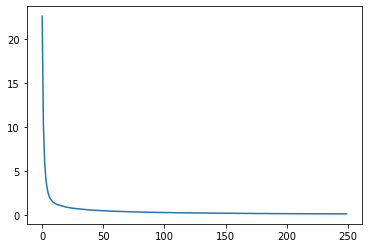

In [14]:
x= range(len(d["loss"]))
_= plt.plot(x,d["loss"])

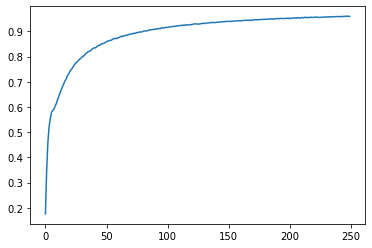

In [15]:
x= range(len(d["accuracy"]))
_= plt.plot(x,d["accuracy"])

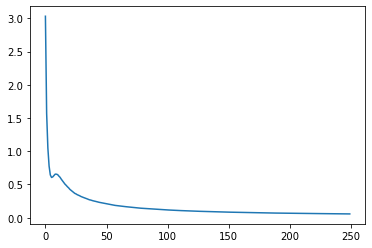

In [16]:
x= range(len(d["val_loss"]))
_= plt.plot(x,d["val_loss"])

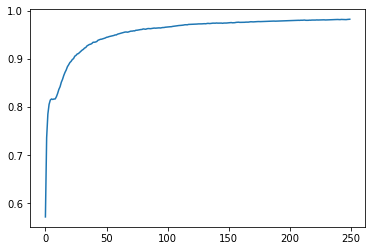

In [17]:
x= range(len(d["val_accuracy"]))
_= plt.plot(x,d["val_accuracy"])

In [47]:
d={'loss': [22.571229934692383,
  10.335871696472168,
  6.109948635101318,
  4.1272125244140625,
  3.1016037464141846,
  2.4336371421813965,
  2.041743278503418,
  1.7853261232376099,
  1.6038233041763306,
  1.458308219909668,
  1.3760160207748413,
  1.2875343561172485,
  1.2264832258224487,
  1.1609575748443604,
  1.121896743774414,
  1.0787242650985718,
  1.0318491458892822,
  0.9977041482925415,
  0.9545130133628845,
  0.9364075660705566,
  0.8979724049568176,
  0.8775693774223328,
  0.8555898666381836,
  0.8221238255500793,
  0.8000975847244263,
  0.7885547280311584,
  0.7681276202201843,
  0.7530555129051208,
  0.7319848537445068,
  0.7208031415939331,
  0.7034688591957092,
  0.6904558539390564,
  0.6759500503540039,
  0.6622772812843323,
  0.6488083600997925,
  0.6314892172813416,
  0.6228706240653992,
  0.6187745332717896,
  0.5985718369483948,
  0.5916908979415894,
  0.5722251534461975,
  0.580276608467102,
  0.5594924092292786,
  0.555302083492279,
  0.5417608022689819,
  0.5354365706443787,
  0.523945152759552,
  0.519014835357666,
  0.5158577561378479,
  0.4992319643497467,
  0.4984670579433441,
  0.4874868392944336,
  0.4824014902114868,
  0.4747413396835327,
  0.47210371494293213,
  0.4600667953491211,
  0.4546281397342682,
  0.44230836629867554,
  0.4515077769756317,
  0.44907838106155396,
  0.43689295649528503,
  0.4338133931159973,
  0.4160824418067932,
  0.42480432987213135,
  0.4172985553741455,
  0.40939339995384216,
  0.40631940960884094,
  0.39994436502456665,
  0.3923366069793701,
  0.3902750611305237,
  0.3859991133213043,
  0.3875753581523895,
  0.37908703088760376,
  0.37722721695899963,
  0.3759789764881134,
  0.3657592833042145,
  0.3627775013446808,
  0.3617583215236664,
  0.3536018133163452,
  0.3550317585468292,
  0.34497272968292236,
  0.3405953049659729,
  0.34537187218666077,
  0.3392258286476135,
  0.3393239378929138,
  0.33574652671813965,
  0.3273515999317169,
  0.32560503482818604,
  0.3220316767692566,
  0.3208162188529968,
  0.3173814117908478,
  0.31309974193573,
  0.3119923770427704,
  0.3120967745780945,
  0.3102223873138428,
  0.3036940097808838,
  0.30120325088500977,
  0.30065223574638367,
  0.298307329416275,
  0.295396625995636,
  0.29126542806625366,
  0.2908851206302643,
  0.2889742851257324,
  0.28735247254371643,
  0.28434428572654724,
  0.2763824462890625,
  0.2790781259536743,
  0.2759306728839874,
  0.2721720337867737,
  0.2753470242023468,
  0.27135398983955383,
  0.26709622144699097,
  0.26515883207321167,
  0.26399174332618713,
  0.2650022506713867,
  0.2581033706665039,
  0.26098665595054626,
  0.2582728862762451,
  0.26054856181144714,
  0.25188666582107544,
  0.2529369592666626,
  0.2511942684650421,
  0.2484438121318817,
  0.24308809638023376,
  0.24545450508594513,
  0.2492080181837082,
  0.2468338906764984,
  0.23913659155368805,
  0.23953895270824432,
  0.2367609441280365,
  0.2422270029783249,
  0.23594450950622559,
  0.23479217290878296,
  0.23172472417354584,
  0.22821305692195892,
  0.22727654874324799,
  0.22396329045295715,
  0.22607867419719696,
  0.2236178070306778,
  0.22751115262508392,
  0.22147159278392792,
  0.21871577203273773,
  0.2227349430322647,
  0.2192428708076477,
  0.21826471388339996,
  0.21498441696166992,
  0.21339920163154602,
  0.21217504143714905,
  0.2123773992061615,
  0.2115698903799057,
  0.21043212711811066,
  0.20961105823516846,
  0.20906615257263184,
  0.2039128690958023,
  0.20526400208473206,
  0.20645500719547272,
  0.20263008773326874,
  0.19836729764938354,
  0.1989881992340088,
  0.20229390263557434,
  0.20132537186145782,
  0.1982845813035965,
  0.19469791650772095,
  0.19626320898532867,
  0.196788489818573,
  0.19283917546272278,
  0.1970822960138321,
  0.18769556283950806,
  0.19411765038967133,
  0.19014285504817963,
  0.19087620079517365,
  0.18811053037643433,
  0.18524670600891113,
  0.1865449696779251,
  0.18232013285160065,
  0.18410730361938477,
  0.17757755517959595,
  0.18537765741348267,
  0.17992641031742096,
  0.1798526793718338,
  0.18243567645549774,
  0.17947164177894592,
  0.17801135778427124,
  0.17529979348182678,
  0.1756168156862259,
  0.17679807543754578,
  0.1763361692428589,
  0.17852026224136353,
  0.17050957679748535,
  0.16796477138996124,
  0.1714116483926773,
  0.17167720198631287,
  0.16723336279392242,
  0.16891609132289886,
  0.16874544322490692,
  0.16735504567623138,
  0.16677559912204742,
  0.16374513506889343,
  0.16801704466342926,
  0.16283190250396729,
  0.16497312486171722,
  0.16380763053894043,
  0.16186784207820892,
  0.16010025143623352,
  0.15797856450080872,
  0.16611401736736298,
  0.15758571028709412,
  0.15639418363571167,
  0.1588117927312851,
  0.15944801270961761,
  0.15445105731487274,
  0.15779000520706177,
  0.1550067812204361,
  0.15386302769184113,
  0.15753403306007385,
  0.15765541791915894,
  0.15355759859085083,
  0.15044479072093964,
  0.15291817486286163,
  0.1552068293094635,
  0.1487315148115158,
  0.15337781608104706,
  0.1497904360294342,
  0.1505456566810608,
  0.1533621847629547,
  0.1531863808631897,
  0.1495659202337265,
  0.14895060658454895,
  0.14714747667312622,
  0.1471671164035797,
  0.148018941283226,
  0.14718399941921234,
  0.1448180228471756,
  0.14542318880558014,
  0.14796355366706848,
  0.1468690037727356,
  0.14289595186710358,
  0.14092375338077545,
  0.1412864327430725,
  0.14173370599746704,
  0.14008599519729614,
  0.14077959954738617,
  0.13930021226406097,
  0.13948489725589752,
  0.14315178990364075,
  0.13522018492221832,
  0.13667328655719757,
  0.13636359572410583,
  0.13732314109802246,
  0.13888046145439148],
 'accuracy': [0.17578333616256714,
  0.34564998745918274,
  0.45855000615119934,
  0.5215666890144348,
  0.5545499920845032,
  0.5786833167076111,
  0.5866833329200745,
  0.5913000106811523,
  0.604533314704895,
  0.614383339881897,
  0.6303166747093201,
  0.6432666778564453,
  0.6559833288192749,
  0.6691333055496216,
  0.6802499890327454,
  0.6917499899864197,
  0.7032166719436646,
  0.7111499905586243,
  0.7249333262443542,
  0.7304499745368958,
  0.7404999732971191,
  0.7483500242233276,
  0.7539666891098022,
  0.7615333199501038,
  0.7699000239372253,
  0.7752500176429749,
  0.7796833515167236,
  0.7840333580970764,
  0.7902666926383972,
  0.7928666472434998,
  0.798383355140686,
  0.8014833331108093,
  0.8052166700363159,
  0.8120166659355164,
  0.8148166537284851,
  0.8197833299636841,
  0.8204666376113892,
  0.8238000273704529,
  0.8289333581924438,
  0.8317166566848755,
  0.8352000117301941,
  0.8339999914169312,
  0.8393666744232178,
  0.8429333567619324,
  0.8451333045959473,
  0.8460333347320557,
  0.8509666919708252,
  0.851016640663147,
  0.8532666563987732,
  0.8566499948501587,
  0.8590666651725769,
  0.8612499833106995,
  0.8631666898727417,
  0.8641666769981384,
  0.8648999929428101,
  0.8692833185195923,
  0.8701833486557007,
  0.8729333281517029,
  0.8705000281333923,
  0.8737833499908447,
  0.8745333552360535,
  0.8780166506767273,
  0.8810666799545288,
  0.8785333037376404,
  0.8825666904449463,
  0.8830999732017517,
  0.883983314037323,
  0.8858333230018616,
  0.8863833546638489,
  0.8888000249862671,
  0.8902333378791809,
  0.8896166682243347,
  0.8920666575431824,
  0.892549991607666,
  0.8931333422660828,
  0.895466685295105,
  0.8954166769981384,
  0.8968166708946228,
  0.8982666730880737,
  0.8974499702453613,
  0.9002833366394043,
  0.9020500183105469,
  0.9013166427612305,
  0.9020833373069763,
  0.9035833477973938,
  0.9051333069801331,
  0.9064833521842957,
  0.9064499735832214,
  0.9078166484832764,
  0.9077666401863098,
  0.9082499742507935,
  0.9104833602905273,
  0.909766674041748,
  0.9115333557128906,
  0.9105833172798157,
  0.9136833548545837,
  0.9139999747276306,
  0.9135500192642212,
  0.9156666398048401,
  0.9155499935150146,
  0.9156500101089478,
  0.9168499708175659,
  0.9179166555404663,
  0.9185500144958496,
  0.9195333123207092,
  0.9198333621025085,
  0.9199333190917969,
  0.9215333461761475,
  0.9213333129882812,
  0.921833336353302,
  0.9229666590690613,
  0.9235000014305115,
  0.923966646194458,
  0.9246000051498413,
  0.9237666726112366,
  0.9267666935920715,
  0.9251499772071838,
  0.9252333045005798,
  0.9261999726295471,
  0.9268166422843933,
  0.9269833564758301,
  0.928933322429657,
  0.9292333126068115,
  0.9301499724388123,
  0.9290500283241272,
  0.9282666444778442,
  0.9295166730880737,
  0.9300833344459534,
  0.9310500025749207,
  0.9319833517074585,
  0.9312333464622498,
  0.9316499829292297,
  0.9332333207130432,
  0.933566689491272,
  0.9336666464805603,
  0.9349499940872192,
  0.9347833395004272,
  0.9348499774932861,
  0.9351500272750854,
  0.9347000122070312,
  0.9362499713897705,
  0.9362999796867371,
  0.9361500144004822,
  0.9374666810035706,
  0.9376166462898254,
  0.9378166794776917,
  0.9387333393096924,
  0.9380999803543091,
  0.939633309841156,
  0.9394500255584717,
  0.9395999908447266,
  0.9394999742507935,
  0.9394833445549011,
  0.9406999945640564,
  0.9411333203315735,
  0.9403833150863647,
  0.9417333602905273,
  0.9422666430473328,
  0.9426833391189575,
  0.941016674041748,
  0.9421666860580444,
  0.9421833157539368,
  0.9436666369438171,
  0.9429500102996826,
  0.9444833397865295,
  0.944350004196167,
  0.9429333209991455,
  0.9451833367347717,
  0.9433333277702332,
  0.9443833231925964,
  0.9452333450317383,
  0.9456499814987183,
  0.9464166760444641,
  0.9455666542053223,
  0.9461833238601685,
  0.9458833336830139,
  0.9477999806404114,
  0.9467999935150146,
  0.947516679763794,
  0.9475833177566528,
  0.9483000040054321,
  0.9476500153541565,
  0.9482499957084656,
  0.9493499994277954,
  0.9495333433151245,
  0.948366641998291,
  0.9492499828338623,
  0.948033332824707,
  0.9503999948501587,
  0.9506833553314209,
  0.9502500295639038,
  0.9502500295639038,
  0.9513833522796631,
  0.9509833455085754,
  0.9513499736785889,
  0.9506000280380249,
  0.9507833123207092,
  0.9522500038146973,
  0.9512166380882263,
  0.9524499773979187,
  0.9505000114440918,
  0.9518666863441467,
  0.9521166682243347,
  0.9528833627700806,
  0.9540166854858398,
  0.9520833492279053,
  0.9538333415985107,
  0.9542166590690613,
  0.9521999955177307,
  0.9537500143051147,
  0.9549499750137329,
  0.9536166787147522,
  0.9548500180244446,
  0.9561166763305664,
  0.9541500210762024,
  0.9550833106040955,
  0.9549000263214111,
  0.9561499953269958,
  0.9552000164985657,
  0.9550833106040955,
  0.9560999870300293,
  0.9559000134468079,
  0.9571999907493591,
  0.9561333060264587,
  0.9549333453178406,
  0.9555666446685791,
  0.9563666582107544,
  0.956683337688446,
  0.9567166566848755,
  0.9572499990463257,
  0.956083357334137,
  0.9580833315849304,
  0.957099974155426,
  0.9578499794006348,
  0.9573666453361511,
  0.9571166634559631,
  0.958133339881897,
  0.9581999778747559,
  0.9587833285331726,
  0.9584833383560181,
  0.9589333534240723,
  0.9578333497047424,
  0.9589999914169312,
  0.9594333171844482,
  0.9584333300590515,
  0.9598666429519653,
  0.9599499702453613,
  0.9598166942596436,
  0.9598833322525024,
  0.9592333436012268],
 'val_loss': [3.031341314315796,
  1.5699903964996338,
  1.0497677326202393,
  0.7776825428009033,
  0.6439451575279236,
  0.6056201457977295,
  0.6140367984771729,
  0.6350357532501221,
  0.6557522416114807,
  0.6547847390174866,
  0.6481831073760986,
  0.6264583468437195,
  0.6074733138084412,
  0.579046368598938,
  0.553992748260498,
  0.529743492603302,
  0.5051908493041992,
  0.4870063066482544,
  0.4659081995487213,
  0.4488614797592163,
  0.42676079273223877,
  0.4111696779727936,
  0.3950824439525604,
  0.38081082701683044,
  0.3665113151073456,
  0.3582788407802582,
  0.3464433252811432,
  0.3384303152561188,
  0.3304852843284607,
  0.3197755515575409,
  0.3119647800922394,
  0.3054560422897339,
  0.2980692982673645,
  0.29203084111213684,
  0.2845522165298462,
  0.27637308835983276,
  0.26948094367980957,
  0.2657376825809479,
  0.25997260212898254,
  0.2543179988861084,
  0.2505413591861725,
  0.24574440717697144,
  0.2408403605222702,
  0.2363845705986023,
  0.23154672980308533,
  0.2278728485107422,
  0.22292949259281158,
  0.21943798661231995,
  0.21661514043807983,
  0.21243813633918762,
  0.2081778347492218,
  0.20444804430007935,
  0.20085109770298004,
  0.19767050445079803,
  0.19493651390075684,
  0.19196482002735138,
  0.18806864321231842,
  0.1852509081363678,
  0.18288055062294006,
  0.18175843358039856,
  0.17855945229530334,
  0.1758742332458496,
  0.17315948009490967,
  0.17167021334171295,
  0.1697779893875122,
  0.1676325798034668,
  0.16541962325572968,
  0.16345477104187012,
  0.161615788936615,
  0.15938511490821838,
  0.15756450593471527,
  0.15535525977611542,
  0.15353776514530182,
  0.1520182341337204,
  0.1499948650598526,
  0.14813609421253204,
  0.14680637419223785,
  0.1449691355228424,
  0.14304989576339722,
  0.14179463684558868,
  0.14036481082439423,
  0.13872858881950378,
  0.13727016746997833,
  0.13587906956672668,
  0.13430863618850708,
  0.13323929905891418,
  0.13211265206336975,
  0.13078759610652924,
  0.12960490584373474,
  0.12813253700733185,
  0.12705162167549133,
  0.12598645687103271,
  0.12507428228855133,
  0.12387549132108688,
  0.12283327430486679,
  0.12178769707679749,
  0.12089131772518158,
  0.11983587592840195,
  0.11853891611099243,
  0.11754690110683441,
  0.1167646273970604,
  0.11573144793510437,
  0.11469423770904541,
  0.1134658232331276,
  0.11255492269992828,
  0.1117669939994812,
  0.11100040376186371,
  0.11028022319078445,
  0.10936801880598068,
  0.1081220805644989,
  0.10745365917682648,
  0.10687244683504105,
  0.10606618970632553,
  0.10532866418361664,
  0.10453664511442184,
  0.10381867736577988,
  0.1031174436211586,
  0.10204331576824188,
  0.10130175948143005,
  0.10066673904657364,
  0.09991008788347244,
  0.09938462823629379,
  0.09871770441532135,
  0.09806669503450394,
  0.09751610457897186,
  0.09701088815927505,
  0.09631764143705368,
  0.09572737663984299,
  0.09511946886777878,
  0.09466475993394852,
  0.09394030272960663,
  0.0934094563126564,
  0.09262581914663315,
  0.09214980155229568,
  0.0915430560708046,
  0.09110689908266068,
  0.0906534492969513,
  0.08999553322792053,
  0.08945480734109879,
  0.08898906409740448,
  0.08836733549833298,
  0.08781008422374725,
  0.08718053996562958,
  0.08675672113895416,
  0.08618535101413727,
  0.08581068366765976,
  0.08524076640605927,
  0.08486384153366089,
  0.08436303585767746,
  0.08389611542224884,
  0.08353693038225174,
  0.08322854340076447,
  0.08282335847616196,
  0.08223509043455124,
  0.08178862929344177,
  0.08149821311235428,
  0.08109918981790543,
  0.08077280968427658,
  0.08040028810501099,
  0.08007082343101501,
  0.07974860072135925,
  0.07947584986686707,
  0.0791444182395935,
  0.07856368273496628,
  0.07811081409454346,
  0.0775468498468399,
  0.07717055082321167,
  0.07695940881967545,
  0.07665159553289413,
  0.07623490691184998,
  0.07584399729967117,
  0.07555040717124939,
  0.07503439486026764,
  0.07477319985628128,
  0.07428228855133057,
  0.07390613108873367,
  0.07362920790910721,
  0.07329487055540085,
  0.07312452793121338,
  0.0728532075881958,
  0.07247147709131241,
  0.07206699997186661,
  0.07176759093999863,
  0.07142528891563416,
  0.07123075425624847,
  0.07082061469554901,
  0.07051169127225876,
  0.07029270380735397,
  0.06980574876070023,
  0.06962636858224869,
  0.06952233612537384,
  0.06928159296512604,
  0.06915459036827087,
  0.06873907893896103,
  0.06841115653514862,
  0.0682339072227478,
  0.06809186190366745,
  0.06769560277462006,
  0.06734767556190491,
  0.06719991564750671,
  0.06705415993928909,
  0.06683734804391861,
  0.06652384996414185,
  0.06619293987751007,
  0.06590990722179413,
  0.0657239779829979,
  0.06532961130142212,
  0.06523773074150085,
  0.06495457887649536,
  0.06477101147174835,
  0.06468566507101059,
  0.06446430087089539,
  0.06425376236438751,
  0.06409706920385361,
  0.06385045498609543,
  0.06362196803092957,
  0.06338892877101898,
  0.06304365396499634,
  0.06282585859298706,
  0.06266450881958008,
  0.06252395361661911,
  0.06228814646601677,
  0.062058936804533005,
  0.06196163222193718,
  0.06179120019078255,
  0.06163713335990906,
  0.06126817688345909,
  0.06101376190781593,
  0.060826610773801804,
  0.060617804527282715,
  0.06048405170440674,
  0.060302238911390305,
  0.060186609625816345,
  0.06011736020445824,
  0.05989125370979309,
  0.059747520834207535,
  0.059465229511260986,
  0.0593511126935482,
  0.059119854122400284,
  0.059014324098825455,
  0.0587654784321785,
  0.058509185910224915,
  0.05839913338422775,
  0.0582449696958065,
  0.05810728296637535,
  0.05798839032649994,
  0.057756517082452774,
  0.05757756903767586,
  0.057356707751750946,
  0.05704180896282196],
 'val_accuracy': [0.5719000101089478,
  0.7361999750137329,
  0.7853999733924866,
  0.8057000041007996,
  0.8147000074386597,
  0.8169000148773193,
  0.8159000277519226,
  0.8167999982833862,
  0.8169000148773193,
  0.8216000199317932,
  0.8284000158309937,
  0.8367999792098999,
  0.8424000144004822,
  0.8515999913215637,
  0.857699990272522,
  0.8655999898910522,
  0.871999979019165,
  0.8770999908447266,
  0.883899986743927,
  0.8878999948501587,
  0.8924999833106995,
  0.8949999809265137,
  0.8988000154495239,
  0.9006999731063843,
  0.9057000279426575,
  0.9074000120162964,
  0.9103000164031982,
  0.9111999869346619,
  0.9136000275611877,
  0.9161999821662903,
  0.9182999730110168,
  0.9199000000953674,
  0.9225999712944031,
  0.923799991607666,
  0.9271000027656555,
  0.9286999702453613,
  0.9301000237464905,
  0.9307000041007996,
  0.9320999979972839,
  0.9347000122070312,
  0.9347000122070312,
  0.9351999759674072,
  0.9362000226974487,
  0.9387999773025513,
  0.9397000074386597,
  0.9408000111579895,
  0.941100001335144,
  0.9419999718666077,
  0.9427000284194946,
  0.9435999989509583,
  0.9449999928474426,
  0.9453999996185303,
  0.946399986743927,
  0.9470000267028809,
  0.9473999738693237,
  0.9480000138282776,
  0.9488000273704529,
  0.9498999714851379,
  0.9498999714851379,
  0.9514999985694885,
  0.9521999955177307,
  0.9527999758720398,
  0.9534000158309937,
  0.9545000195503235,
  0.9549999833106995,
  0.9557999968528748,
  0.9560999870300293,
  0.9556000232696533,
  0.9560999870300293,
  0.957099974155426,
  0.9577999711036682,
  0.9577999711036682,
  0.9584000110626221,
  0.958299994468689,
  0.9595999717712402,
  0.9596999883651733,
  0.9602000117301941,
  0.9606999754905701,
  0.9610999822616577,
  0.9613000154495239,
  0.9624000191688538,
  0.9620000123977661,
  0.9617000222206116,
  0.9625999927520752,
  0.9631999731063843,
  0.9629999995231628,
  0.9628999829292297,
  0.9634000062942505,
  0.9641000032424927,
  0.9642000198364258,
  0.9639000296592712,
  0.9642000198364258,
  0.9646999835968018,
  0.9646000266075134,
  0.9642999768257141,
  0.964900016784668,
  0.9653000235557556,
  0.9653000235557556,
  0.9659000039100647,
  0.9661999940872192,
  0.9666000008583069,
  0.9666000008583069,
  0.9668999910354614,
  0.9670000076293945,
  0.9675999879837036,
  0.9678999781608582,
  0.9681000113487244,
  0.9685999751091003,
  0.968999981880188,
  0.9693999886512756,
  0.9695000052452087,
  0.9697999954223633,
  0.9700000286102295,
  0.9703999757766724,
  0.9710000157356262,
  0.9710999727249146,
  0.9708999991416931,
  0.9717000126838684,
  0.9718000292778015,
  0.9717000126838684,
  0.972100019454956,
  0.972000002861023,
  0.9721999764442444,
  0.9721999764442444,
  0.9725000262260437,
  0.9728000164031982,
  0.9728000164031982,
  0.9728000164031982,
  0.9728999733924866,
  0.9731000065803528,
  0.9732999801635742,
  0.9731000065803528,
  0.9735999703407288,
  0.9739999771118164,
  0.9735999703407288,
  0.9736999869346619,
  0.9740999937057495,
  0.974399983882904,
  0.974399983882904,
  0.9743000268936157,
  0.9746999740600586,
  0.974399983882904,
  0.9745000004768372,
  0.9746000170707703,
  0.9745000004768372,
  0.9740999937057495,
  0.9746000170707703,
  0.9745000004768372,
  0.9746000170707703,
  0.9747999906539917,
  0.9751999974250793,
  0.9751999974250793,
  0.975600004196167,
  0.9750999808311462,
  0.9753000140190125,
  0.9753999710083008,
  0.9760000109672546,
  0.9761000275611877,
  0.9764000177383423,
  0.9760000109672546,
  0.9760000109672546,
  0.9757999777793884,
  0.9761999845504761,
  0.9761999845504761,
  0.9764999747276306,
  0.9764999747276306,
  0.9764999747276306,
  0.9768000245094299,
  0.9772999882698059,
  0.9771000146865845,
  0.9769999980926514,
  0.9771999716758728,
  0.9772999882698059,
  0.9775999784469604,
  0.9776999950408936,
  0.9775999784469604,
  0.9775999784469604,
  0.9776999950408936,
  0.9775999784469604,
  0.9779999852180481,
  0.9778000116348267,
  0.9779999852180481,
  0.9782000184059143,
  0.9782000184059143,
  0.9782999753952026,
  0.9782999753952026,
  0.9785000085830688,
  0.9786999821662903,
  0.9785000085830688,
  0.978600025177002,
  0.9789000153541565,
  0.9787999987602234,
  0.9789999723434448,
  0.9790999889373779,
  0.9790999889373779,
  0.979200005531311,
  0.9794999957084656,
  0.9796000123023987,
  0.9793999791145325,
  0.9797000288963318,
  0.9794999957084656,
  0.9797999858856201,
  0.9797999858856201,
  0.9799000024795532,
  0.9800000190734863,
  0.9801999926567078,
  0.9801999926567078,
  0.9803000092506409,
  0.9801999926567078,
  0.9804999828338623,
  0.980400025844574,
  0.9805999994277954,
  0.9807999730110168,
  0.9803000092506409,
  0.9803000092506409,
  0.9803000092506409,
  0.9805999994277954,
  0.9804999828338623,
  0.9807999730110168,
  0.9807000160217285,
  0.9807999730110168,
  0.9807999730110168,
  0.9811000227928162,
  0.98089998960495,
  0.9810000061988831,
  0.9810000061988831,
  0.9810000061988831,
  0.9811000227928162,
  0.9812999963760376,
  0.9810000061988831,
  0.9811000227928162,
  0.9811999797821045,
  0.9811999797821045,
  0.9814000129699707,
  0.9815000295639038,
  0.9814000129699707,
  0.9817000031471252,
  0.9817000031471252,
  0.9817000031471252,
  0.9819999933242798,
  0.9818000197410583,
  0.9817000031471252,
  0.9821000099182129,
  0.9819999933242798,
  0.9818000197410583,
  0.9819999933242798,
  0.9817000031471252,
  0.9821000099182129,
  0.982200026512146,
  0.9825000166893005]}



# Bout de code

In [66]:
mod_prov= make_pipeline(MinMaxScaler(),LogisticRegression(class_weight='balanced', max_iter=2000, 
                                                          solver='newton-cg'))

mod_prov.fit(X_train_red, Y_train_red)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='newton-cg'))])

In [ ]:

err, pre, d= erreur_prediction(valeurs_predites= prediction, valeurs_reelle= Y_test_red)
print(f"{err} erreurs sur {len(X_test_red)} images soit une précision de {pre:.2f} %")
print(f"Dictionnaire des erreurs (clé valeur réelle: valeur prédite):\n{d}")

In [240]:
loaded_model = tf.keras.models.load_model('./modeles/CNN-32-64-F-256-Do_C32-33C64-33Mp22Do25FD256Do50D10_Ep250.modele')
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2359552   
                                                      

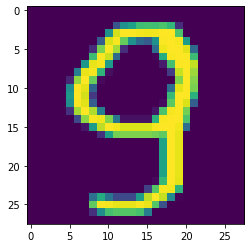

In [236]:
#img= plt.imread("./images/0_001.png")
img= Image.open("./images/9_001.png")
plt.imshow(img)

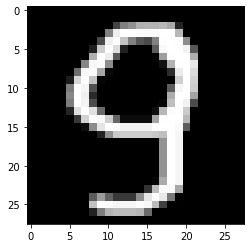

In [238]:
plt.imshow(chiffre, cmap="gray")

In [235]:
tab

[0.09793539,
 0.09754746,
 0.101428315,
 0.102093235,
 0.09930367,
 0.09967575,
 0.09809451,
 0.09840351,
 0.10627594,
 0.09924221]

In [70]:
tmax= max(tab)
np.where(tab== tab.max())[0][0]

5

In [47]:
tab

array([0.09363423, 0.10297393, 0.09852049, 0.10418213, 0.09446587,
       0.11083828, 0.09819234, 0.0971067 , 0.0970629 , 0.10302322],
      dtype=float32)

In [120]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2359552   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                      

In [48]:
A=np.array([0,2,2,3,4,3,4,0])
np.where(A== A.max())

(array([4, 6]),)